In [1]:
pip install python-chess


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 6.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import os
import chess
import h5py
from keras.utils import to_categorical
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, Input

2024-06-21 02:06:12.426486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 02:06:12.426631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 02:06:12.536676: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:


# Load the .h5 file
with h5py.File("/kaggle/input/grandmaster-datasets/valid_processed_magnus_dataset_300000.h5", "r") as hf:
    # Load datasets into memory
    feature_board = hf["board_matrix"][:]
    game_id = hf["GameID"][:]
    move_id = hf["MoveID"][:]
    player_move = hf["PlayerMove"][:]
    top_moves_list = hf["TopMoves"][:]
    best_move = hf["BestMove"][:]
    centipawns = hf["Centipawns"][:]
    mates = hf["Mates"][:]
    move_sequence = hf["MoveSequence"][:]
    

# Now you can work with the loaded data outside the `with` block
# Example: Print shapes of the datasets
print("Shapes of datasets:")
print(f"  game_id: {game_id.shape}")
print(f"  move_id: {move_id.shape}")
print(f"  player_move: {player_move.shape}")
print(f"  top_moves_list: {top_moves_list.shape}")
print(f"  best_move: {best_move.shape}")
print(f"  centipawns: {centipawns.shape}")
print(f"  mates: {mates.shape}")
print(f"  move_sequence: {move_sequence.shape}")


Shapes of datasets:
  game_id: (300000,)
  move_id: (300000,)
  player_move: (300000,)
  top_moves_list: (300000, 5)
  best_move: (300000,)
  centipawns: (300000, 5)
  mates: (300000, 5)
  move_sequence: (300000, 5)


In [4]:
# Calculate correlation between player_move and best_move
# Note: Since these are strings, we can't calculate correlation directly.
# Converting to integers for the purpose of correlation calculation.
unique_moves = np.unique(np.concatenate((player_move, best_move)))
move_to_int = {move: idx for idx, move in enumerate(unique_moves)}

player_move_int = np.array([move_to_int[move] for move in player_move])
best_move_int = np.array([move_to_int[move] for move in best_move])

correlation = np.corrcoef(player_move_int, best_move_int)[0, 1]
print(f"Correlation between player_move and best_move: {correlation}")

# Count rows where player_move is in best_move array
best_move_contains_player_move = np.array([player_move[i] == best_move[i] for i in range(len(player_move))])
best_move_count = np.sum(best_move_contains_player_move)
best_move_percentage = (best_move_count / len(player_move)) * 100
print(f"Number of rows where player_move is equal to best_move: {best_move_count}")
print(f"Percentage of rows where player_move is equal to best_move: {best_move_percentage:.2f}%")

# Count rows where player_move is in top_moves_list array
top_moves_contains_player_move = np.array([player_move[i] in top_moves_list[i][:2] for i in range(len(player_move))])
top_moves_count = np.sum(top_moves_contains_player_move)
top_moves_percentage = (top_moves_count / len(player_move)) * 100
print(f"Number of rows where player_move is in top_moves_list array: {top_moves_count}")
print(f"Percentage of rows where player_move is in top_moves_list array: {top_moves_percentage:.2f}%")

# Count rows where player_move is in move_sequence array
move_sequence_contains_player_move = np.array([player_move[i] in move_sequence[i][:2] for i in range(len(player_move))])
move_sequence_count = np.sum(move_sequence_contains_player_move)
move_sequence_percentage = (move_sequence_count / len(player_move)) * 100
print(f"Number of rows where player_move is in move_sequence array: {move_sequence_count}")
print(f"Percentage of rows where player_move is in move_sequence array: {move_sequence_percentage:.2f}%")


Correlation between player_move and best_move: 0.5173055719181198
Number of rows where player_move is equal to best_move: 126191
Percentage of rows where player_move is equal to best_move: 42.06%
Number of rows where player_move is in top_moves_list array: 219111
Percentage of rows where player_move is in top_moves_list array: 73.04%
Number of rows where player_move is in move_sequence array: 169079
Percentage of rows where player_move is in move_sequence array: 56.36%


In [5]:

# Convert move to label
def move_to_label(move):
    from_square = move.from_square
    to_square = move.to_square
    return from_square * 64 + to_square
# Function to represent a move on an 8x8 grid
def move_to_grid(move):
    
    from_square = move.from_square
    to_square = move.to_square
    
    # Initialize an empty 8x8 grid
    grid = np.zeros((8, 8), dtype=np.int8)
    
    # Convert the from_square and to_square to row, col format
    from_row, from_col = divmod(from_square, 8)
    to_row, to_col = divmod(to_square, 8)
    
    # Encode the move
    grid[from_row, from_col] = 1  # Starting position
    grid[to_row, to_col] = 2      # Ending position
    return grid
def standardize(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    print(mean,std_dev)
    standardized_data = (data - mean) / std_dev
    return standardized_data

best_move =[move.decode('utf-8') if isinstance(move, bytes) else move for move in best_move]
matrix_best_move = [move_to_label(chess.Move.from_uci(move)) for move in best_move]
matrix_best_move = np.array(matrix_best_move)
best_move_one_hot = np.array(tf.one_hot(matrix_best_move, depth=4096, dtype=tf.uint8))


playerMove =[move.decode('utf-8') if isinstance(move, bytes) else move for move in player_move]
matrix_playerMove = [move_to_label(chess.Move.from_uci(move)) for move in playerMove]
matrix_playerMove = np.array(matrix_playerMove)
y_one_hot =  np.array(tf.one_hot(matrix_playerMove, depth=4096, dtype=tf.uint8))




# Convert top moves list to labels
matrix_top_moves = []
matrix_move_sequence = []

for moves_list in top_moves_list:
    moves_list_str = [move.decode('utf-8') if isinstance(move, bytes) else move for move in moves_list]
    
    # Create labels, filtering out empty moves
    labels = [move_to_label(chess.Move.from_uci(move))if move else -1 for move in moves_list_str]
    matrix_top_moves.append(labels)

for move_seq in move_sequence:
 
    move_sequence_str = [move.decode('utf-8') if isinstance(move, bytes) else move for move in move_seq]
    
    # Create labels, filtering out empty moves
    labels = [move_to_label(chess.Move.from_uci(move))if move else -1 for move in move_sequence_str]
    matrix_move_sequence.append(labels)    
    
# Convert to numpy array
matrix_top_moves = np.array(matrix_top_moves)[:,:2]

feature_board = np.array(feature_board)
matrix_move_sequence = np.array(matrix_move_sequence)[:,:2] 


standardized_centipawns = standardize(centipawns)[:,:2]
standardized_mates = standardize(mates)[:,:2]

# Print shapes of the standardized datasets and first few elements to check
print("Shapes of standardized datasets:")
print(f"standardized_centipawns: {standardized_centipawns.shape}")
print(f"standardized_mates: {standardized_mates.shape}")

print("Shape of features:", feature_board.shape)
print("Shape of top moves:", matrix_top_moves.shape)
print("Shape of move sequence:", matrix_move_sequence.shape)
print("Shape of y:", y_one_hot.shape)
print("All preprocessing done.....")


-24.645909333333332 191.5498703657434
-0.007666 0.47675210096792786
Shapes of standardized datasets:
standardized_centipawns: (300000, 2)
standardized_mates: (300000, 2)
Shape of features: (300000, 14, 8, 8)
Shape of top moves: (300000, 2)
Shape of move sequence: (300000, 2)
Shape of y: (300000, 4096)
All preprocessing done.....


In [6]:

#53 acc
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate, BatchNormalization

# Define the first input (14, 8, 8) - feature_board
input1 = Input(shape=(14, 8, 8))

# Convolutional layers for the first input
x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D((2, 2))(x1)

x1 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = Flatten()(x1)
x1 = Dense(256, activation='relu')(x1)

# Define the second input (2) - standardized_centipawns
input2 = Input(shape=(2,))

# Define the third input (2) - standardized_mates
input3 = Input(shape=(2,))

# Define the fourth input (2, 4096) - matrix_move_sequence
input4 = Input(shape=(2, 4096))

# Define the fifth input (2, 4096) - matrix_top_moves
input5 = Input(shape=(2, 4096))

# Define the sixth input (4096) - best_move_one_hot
input6 = Input(shape=(4096,))

# Concatenate the outputs of all inputs after flattening or using global pooling
x2 = Dense(256, activation='relu')(input2)
x3 = Dense(256, activation='relu')(input3)
x5 = Dense(256, activation='relu')(input5)

merged = concatenate([x1, x2, x3, Flatten()(input4), Flatten()(input5), input6])

# Add more fully connected layers after merging all inputs
x = Dense(1024, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(4096, activation='softmax')(x)

# Create the model with six inputs
model = Model(inputs=[input1, input2, input3, input4, input5, input6], outputs=output)

# Display the model's architecture
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 14, 8, 8)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 8, 32) │      2,336 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 14, 8, 32) │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 7, 4, 32)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 4, 128) │     36,992 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 4, 128) │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3584)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 2, 4096)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 2, 4096)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    917,760 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │        768 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │        768 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8192)      │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 8192)      │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 21248)     │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0],    │
│                     │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ input_layer_5[0]

 Total params: 72,076,064 (274.95 MB)

 Trainable params: 72,047,072 (274.84 MB)

 Non-trainable params: 28,992 (113.25 KB)

**With data generator**

In [7]:


# Generator function to yield batches of data
def data_generator(X1, X2, X3, X4, X5, X6, y, batch_size):
    num_samples = len(X1)
 
    while True:
        for i in range(0, num_samples, batch_size):
            X1_batch = X1[i:i+batch_size]
            X2_batch = X2[i:i+batch_size]
            X3_batch = X3[i:i+batch_size]
            X4_batch = X4[i:i+batch_size]
            X5_batch = X5[i:i+batch_size]
            X6_batch = X6[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            
            # Initialize empty array for one-hot encoded X4_batch
            x4_batch_one_hot = np.zeros((len(X4_batch), X4_batch.shape[1], 4096), dtype=np.uint8)
            for i, moves_list in enumerate(X4_batch):
                for j, move in enumerate(moves_list):
                    if move != -1:
                        x4_batch_one_hot[i, j, move] = 1
                        
            # Initialize empty array for one-hot encoded X5_batch
            x5_batch_one_hot = np.zeros((len(X5_batch), X5_batch.shape[1], 4096), dtype=np.uint8)
            for i, moves_list in enumerate(X5_batch):
                for j, move in enumerate(moves_list):
                    if move != -1:
                        x5_batch_one_hot[i, j, move] = 1
                        
            yield (
                (tf.convert_to_tensor(X1_batch, dtype=tf.float32), 
                 tf.convert_to_tensor(X2_batch, dtype=tf.float32),
                 tf.convert_to_tensor(X3_batch, dtype=tf.float32),
                 tf.convert_to_tensor(x4_batch_one_hot, dtype=tf.float32),
                 tf.convert_to_tensor(x5_batch_one_hot, dtype=tf.float32),
                 tf.convert_to_tensor(X6_batch, dtype=tf.float32)),
                tf.convert_to_tensor(y_batch, dtype=tf.float32)
            )



# Compile the model with the custom optimizer
model.compile(optimizer=Adam(learning_rate=0.0001 ), loss='categorical_crossentropy', metrics=['accuracy'])

# Split the data into training and validation sets
X1_train, X1_val, X2_train, X2_val, X3_train, X3_val, X4_train, X4_val, X5_train, X5_val, X6_train, X6_val, y_train, y_val = train_test_split(
    feature_board, standardized_centipawns, standardized_mates, matrix_move_sequence, matrix_top_moves, best_move_one_hot, y_one_hot,
    test_size=0.1,shuffle=False
)

print("Shapes after train-test split:")
print("X1_train shape:", X1_train.shape)
print("X1_val shape:", X1_val.shape)
print("X2_train shape:", X2_train.shape)
print("X2_val shape:", X2_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

# Define batch size and number of epochs
batch_size = 64
epochs_per_cycle = 20

# Calculate steps per epoch
steps_per_epoch = len(X1_train) // batch_size
validation_steps = len(X1_val) // batch_size


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=1e-4,
    restore_best_weights=True
)

# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_delta=1e-4,
    min_lr=1e-7
)

# Train the model using the generator
history = model.fit(
    data_generator(X1_train, X2_train, X3_train, X4_train, X5_train, X6_train, y_train, batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs_per_cycle,
    verbose=1,
    validation_data=data_generator(X1_val, X2_val, X3_val, X4_val, X5_val, X6_val, y_val, batch_size),
    validation_steps=validation_steps,
    callbacks=[early_stopping,reduce_lr]
)

# Optionally, you can print the history to see the training progress
print(history.history)

Shapes after train-test split:
X1_train shape: (270000, 14, 8, 8)
X1_val shape: (30000, 14, 8, 8)
X2_train shape: (270000, 2)
X2_val shape: (30000, 2)
y_train shape: (270000, 4096)
y_val shape: (30000, 4096)
Epoch 1/20


2024-06-21 02:07:09.564825: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 447: 7.58264, expected 6.70096
2024-06-21 02:07:09.564878: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 455: 5.58531, expected 4.82517
2024-06-21 02:07:09.564897: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 679: 8.04975, expected 7.12063
2024-06-21 02:07:09.564925: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2359: 7.03761, expected 6.094
2024-06-21 02:07:09.564939: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2456: 8.23411, expected 7.29049
2024-06-21 02:07:09.564951: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2463: 7.59386, expected 6.65025
2024-06-21 02:07:09.564966: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3135: 8.24029, expected 7.31085
2024-06-21 02:07:09.564982: E external/

   7/4218 ━━━━━━━━━━━━━━━━━━━━ 1:37 23ms/step - accuracy: 0.0000e+00 - loss: 9.4840  

I0000 00:00:1718935636.974469     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718935637.001627     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4216/4218 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0171 - loss: 7.9651

W0000 00:00:1718935728.811664     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4218/4218 ━━━━━━━━━━━━━━━━━━━━ 117s 23ms/step - accuracy: 0.0171 - loss: 7.9646 - val_accuracy: 0.0881 - val_loss: 5.8118 - learning_rate: 1.0000e-04
Epoch 2/20


2024-06-21 02:08:58.950304: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 343: 7.88969, expected 6.91726
2024-06-21 02:08:58.950359: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 440: 8.65977, expected 7.68735
2024-06-21 02:08:58.950369: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 447: 8.52084, expected 7.54841
2024-06-21 02:08:58.950377: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 552: 7.6331, expected 6.70693
2024-06-21 02:08:58.950390: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 559: 7.70069, expected 6.77453
2024-06-21 02:08:58.950400: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1015: 7.61546, expected 6.71339
2024-06-21 02:08:58.950417: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3367: 6.84683, expected 5.89712
2024-06-21 02:08:58.950427: E external/l

   7/4218 ━━━━━━━━━━━━━━━━━━━━ 1:33 22ms/step - accuracy: 0.0918 - loss: 5.3773  

W0000 00:00:1718935745.670104     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4216/4218 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1368 - loss: 5.5874

W0000 00:00:1718935836.550964     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4218/4218 ━━━━━━━━━━━━━━━━━━━━ 107s 23ms/step - accuracy: 0.1369 - loss: 5.5870 - val_accuracy: 0.4052 - val_loss: 3.9619 - learning_rate: 1.0000e-04
Epoch 3/20
4218/4218 ━━━━━━━━━━━━━━━━━━━━ 95s 23ms/step - accuracy: 0.3651 - loss: 3.9880 - val_accuracy: 0.4988 - val_loss: 3.4070 - learning_rate: 1.0000e-04
Epoch 4/20
4218/4218 ━━━━━━━━━━━━━━━━━━━━ 97s 23ms/step - accuracy: 0.4528 - loss: 3.3860 - val_accuracy: 0.5262 - val_loss: 3.2533 - learning_rate: 1.0000e-04
Epoch 5/20
4218/4218 ━━━━━━━━━━━━━━━━━━━━ 97s 23ms/step - accuracy: 0.4937 - loss: 3.0789 - val_accuracy: 0.5285 - val_loss: 3.1281 - learning_rate: 1.0000e-04
Epoch 6/20
4218/4218 ━━━━━━━━━━━━━━━━━━━━ 98s 23ms/step - accuracy: 0.5170 - loss: 2.8830 - val_accuracy: 0.5334 - val_loss: 3.1095 - learning_rate: 1.0000e-04
Epoch 7/20
4218/4218 ━━━━━━━━━━━━━━━━━━━━ 97s 23ms/step - accuracy: 0.5314 - loss: 2.7390 - val_accuracy: 0.5329 - val_loss: 3.1787 - learning_rate: 1.0000e-04
Epoch 8/20
4218/4218 ━━━━━━━━━━━━━━━━━━━━ 98s 23ms

In [10]:
# Save model after training
model.save(f"/kaggle/working/model_update_acc54_2.h5")

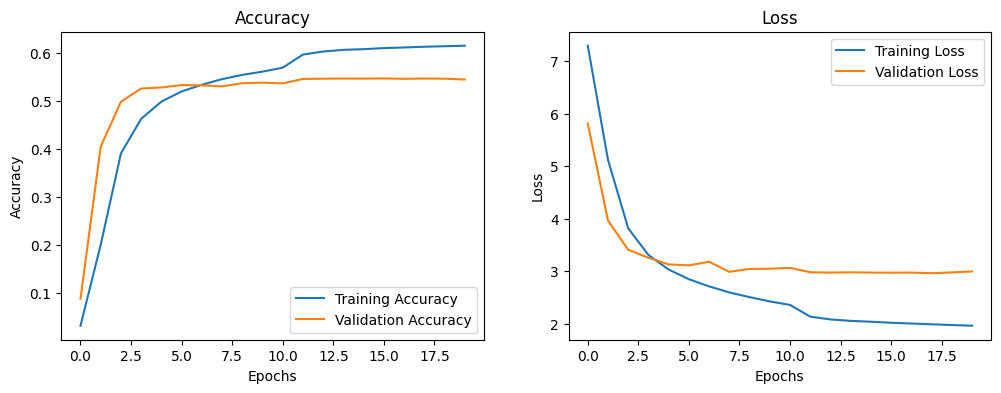

In [9]:
# Plotting the training history
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

